# Regresión Lineal Múltiple

Este notebook implementa un modelo de regresión lineal múltiple usando scikit-learn.

## Características:
- Múltiples variables explicativas (numéricas y categóricas)
- Preprocesamiento con OneHotEncoder para variables categóricas
- Pipeline de preprocesamiento y modelado
- Evaluación con MSE, MAE y R²
- Análisis de coeficientes más influyentes


In [5]:
# Configuración de la ruta y columnas
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Ruta del CSV
CSV_PATH = Path(r'C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\modelos\Data\Global_Cybersecurity_Threats_2015-2024.csv')

# Para regresión múltiple: varias columnas X (numéricas y/o categóricas)
COLS_X_MULTIPLE = [
    'Year',
    'Country',
    'Attack Type',
    'Target Industry',
    'Number of Affected Users',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]

COL_Y = 'Financial Loss (in Million $)'      # variable objetivo

# Carga de datos
if not CSV_PATH.exists():
    raise FileNotFoundError(f'No existe el CSV en: {CSV_PATH.resolve()}')

df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
print('Columnas:', list(df.columns))
df.head()


Shape: (3000, 10)
Columnas: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Incident Resolution Time (in Hours)']


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [6]:
# Regresión lineal múltiple con preprocesamiento
# Verificar que las columnas existen
for col in COLS_X_MULTIPLE:
    if col not in df.columns:
        raise ValueError(f'La columna {col} no existe en el DataFrame.')
if COL_Y not in df.columns:
    raise ValueError('Revisa COL_Y. No existe en el DataFrame.')

X_mult = df[COLS_X_MULTIPLE].copy()
y_mult = df[COL_Y].copy()

# Separar por tipo
dtypes = X_mult.dtypes
num_features = [c for c in X_mult.columns if dtypes[c].kind in ['i', 'u', 'f']]
cat_features = [c for c in X_mult.columns if c not in num_features]

print(f"Variables numéricas: {num_features}")
print(f"Variables categóricas: {cat_features}")

# Preprocesamiento: OneHot para categóricas, passthrough para numéricas
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mult, y_mult, test_size=0.2, random_state=42
)

pipe.fit(X_train_m, y_train_m)

y_pred_m = pipe.predict(X_test_m)
print('--- Regresión lineal múltiple ---')
print('MSE:', mean_squared_error(y_test_m, y_pred_m))
print('MAE:', mean_absolute_error(y_test_m, y_pred_m))
print('R2 :', r2_score(y_test_m, y_pred_m))


Variables numéricas: ['Year', 'Number of Affected Users']
Variables categóricas: ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']
--- Regresión lineal múltiple ---
MSE: 808.9102336257085
MAE: 24.609167373427336
R2 : -0.0003420849970203754


Intercepción: 50.61300635514264

Coeficientes más influyentes (top 20):
Number of Affected Users: -0.0000
Year: 0.0000
Attack Source_Insider: -0.0000
Target Industry_Education: -0.0000
Target Industry_Government: 0.0000
Country_India: -0.0000
Defense Mechanism Used_Antivirus: 0.0000
Country_Germany: 0.0000
Attack Type_DDoS: 0.0000
Attack Type_Malware: -0.0000
Attack Source_Unknown: 0.0000
Attack Type_Ransomware: -0.0000
Attack Source_Nation-state: 0.0000
Defense Mechanism Used_Firewall: -0.0000
Defense Mechanism Used_VPN: -0.0000
Country_China: -0.0000
Target Industry_IT: 0.0000
Target Industry_Healthcare: -0.0000
Attack Type_Phishing: 0.0000
Country_USA: 0.0000


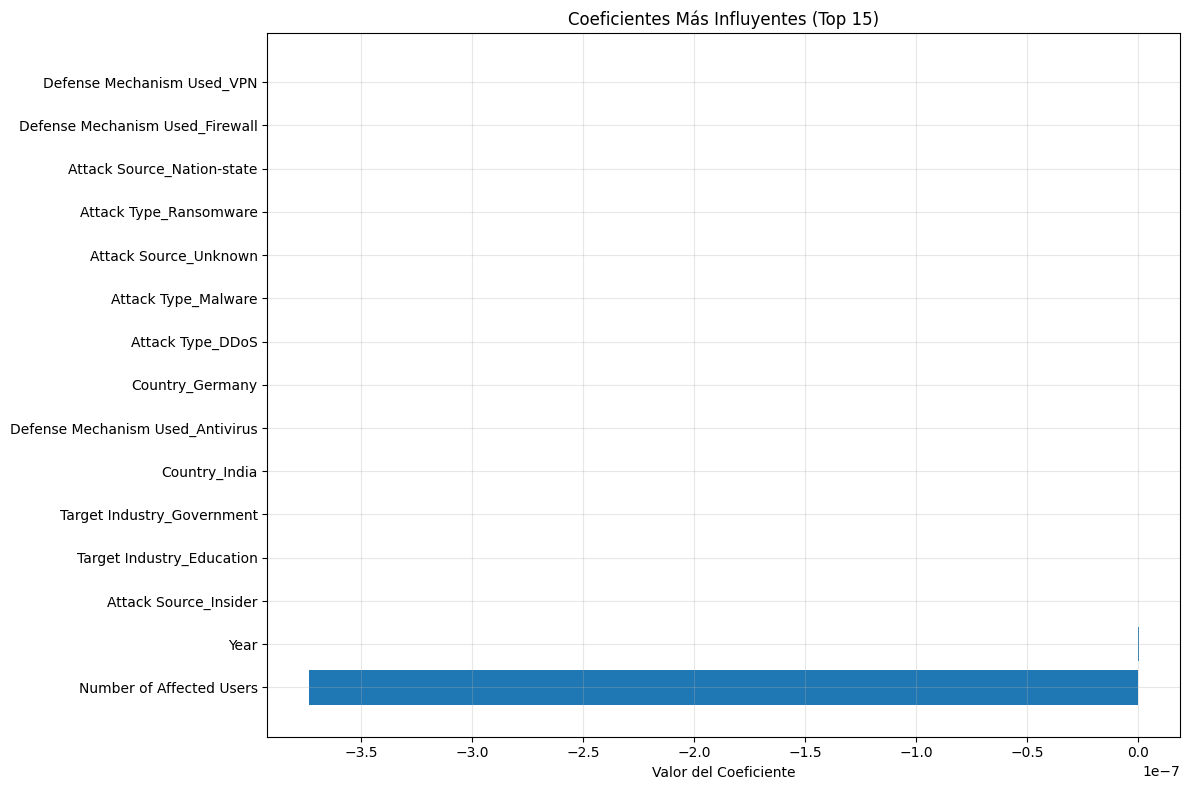

In [7]:
# Análisis de coeficientes
# Extraer coeficientes (requiere obtener los nombres de las características tras OneHot)
feature_names = []
if cat_features:
    ohe: OneHotEncoder = pipe.named_steps['preprocess'].named_transformers_['cat']
    ohe_names = list(ohe.get_feature_names_out(cat_features))
    feature_names.extend(ohe_names)
feature_names.extend(num_features)

coef = pipe.named_steps['model'].coef_
intercept = pipe.named_steps['model'].intercept_
print('Intercepción:', intercept)

# Mostrar los coeficientes pareados con nombre de feature
coef_table = sorted(zip(feature_names, coef), key=lambda x: -abs(x[1]))
print('\nCoeficientes más influyentes (top 20):')
for name, c in coef_table[:20]:  # muestra los 20 más influyentes
    print(f'{name}: {c:.4f}')

# Visualización de coeficientes
plt.figure(figsize=(12, 8))
top_coefs = coef_table[:15]  # Top 15 coeficientes
names, values = zip(*top_coefs)
plt.barh(range(len(names)), values)
plt.yticks(range(len(names)), names)
plt.xlabel('Valor del Coeficiente')
plt.title('Coeficientes Más Influyentes (Top 15)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


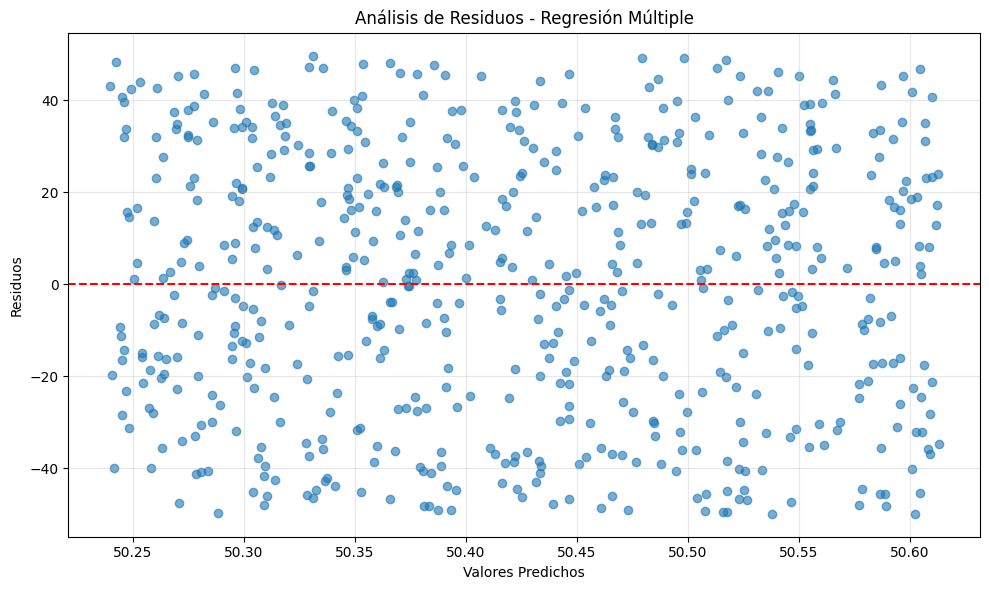

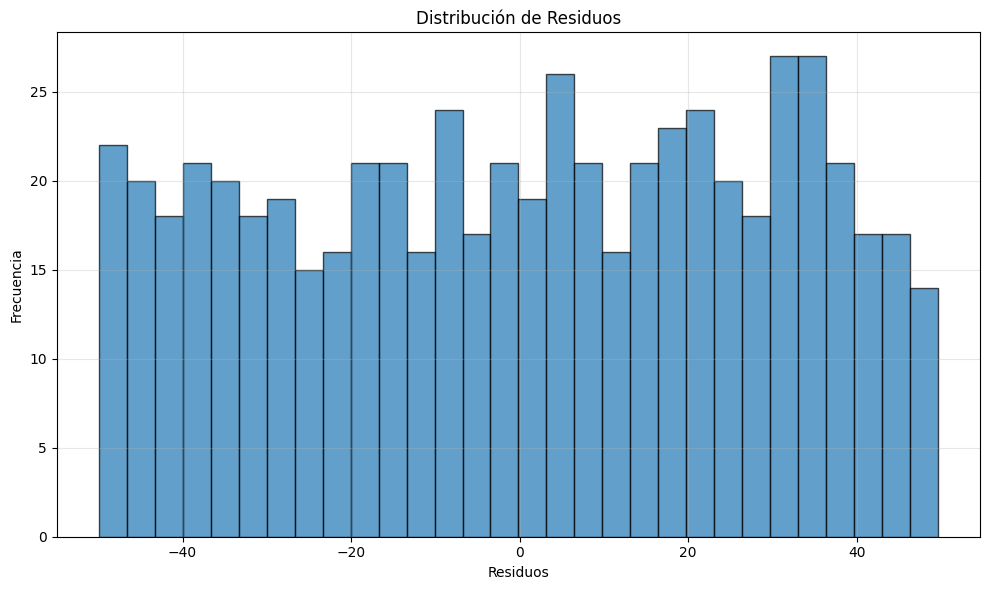

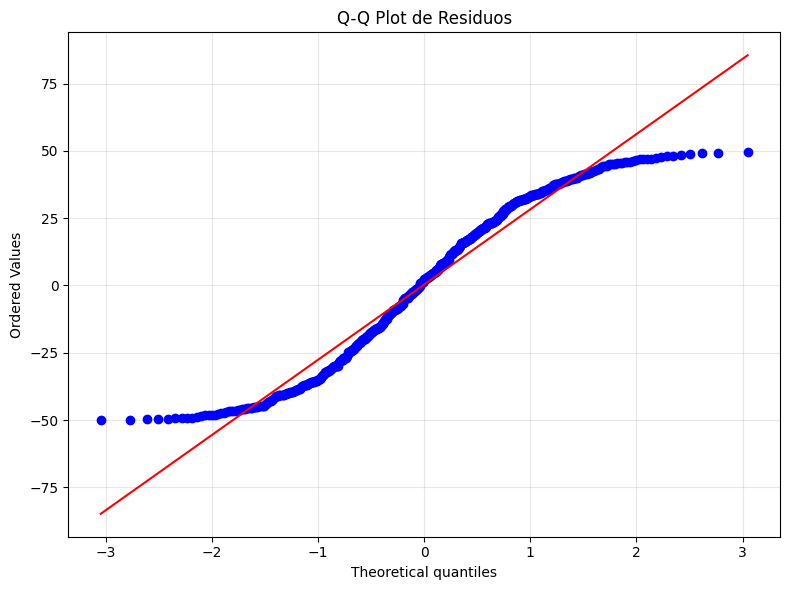

In [8]:
# Análisis de residuos
residuos = y_test_m - y_pred_m

# Gráfico de residuos vs valores predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_m, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos - Regresión Múltiple')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de Residuos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Q-Q plot para verificar normalidad de residuos
from scipy import stats
plt.figure(figsize=(8, 6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
